# **Credit Card Fraud Detection**

The project demonstrates a complete end-to-end ML workflow:

** 1. Exploratory Data Analysis (EDA)**

Examined class imbalance, distribution of transaction amounts, and correlation structure.

Identified that fraud accounts for < 0.2% of all transactions — requiring careful resampling.

**2. Data Preprocessing**

Feature scaling using StandardScaler for the Amount variable.

Removal or transformation of Time field.

Construction of training and test splits using stratified sampling to preserve fraud ratios.

** 3. Imbalance Handling with SMOTE**

Applied Synthetic Minority Oversampling Technique (SMOTE) to generate synthetic fraud samples.

Ensures that machine learning models receive balanced training signals.

** 4. Model Training**

Trained and evaluated multiple ML models:

Logistic Regression

Random Forest Classifier

XGBoost Classifier

Models were compared using:

ROC Curve & AUC score

Precision-Recall Curve & Average Precision

Confusion Matrix

Custom threshold-based evaluation for fraud-detection sensitivity

**5. Visualization**

ROC curves for classifier separability

PR curves to highlight handling of imbalanced data

Feature importance plots (Random Forest, XGBoost)

Threshold vs Precision/Recall plots to tune decision boundaries for real business needs

 6. Outputs **bold text**

Saved trained models (.joblib)

Generated plots (ROC, PR, Threshold, Feature Importance)

Produced evaluation summary CSV

In [11]:

import os
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve,
                             precision_recall_curve, average_precision_score)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [12]:
# ------------------------
# Configuration
# ------------------------
DATA_PATH = 'creditcard.csv'  # Set to your real dataset path if available
USE_SAMPLE_IF_MISSING = True   # If True, use synthetic sample data when the real file is absent
RANDOM_STATE = 42


In [13]:
# ------------------------
# Utility: build a small synthetic dataset for testing/demo
# ------------------------
def build_sample_dataset(n_samples=1000, fraud_ratio=0.02, n_pca=10):
    np.random.seed(RANDOM_STATE)
    # Create synthetic 'V' features (PCA-like) and 'Amount', 'Time', and 'Class'
    data = {}
    for i in range(1, n_pca + 1):
        data[f'V{i}'] = np.random.normal(0, 1, size=n_samples)
    # Amount is positive skewed
    data['Amount'] = np.abs(np.random.exponential(scale=50, size=n_samples))
    data['Time'] = np.random.randint(0, 86400, size=n_samples)  # seconds in a day

    # Binary target with specified fraud ratio
    n_fraud = max(1, int(n_samples * fraud_ratio))
    classes = np.zeros(n_samples, dtype=int)
    fraud_idxs = np.random.choice(n_samples, n_fraud, replace=False)
    classes[fraud_idxs] = 1
    data['Class'] = classes

    df = pd.DataFrame(data)
    return df

In [17]:
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [18]:
# ------------------------
# Load data (robust)
# ------------------------
if os.path.exists(DATA_PATH):
    print(f"Loading dataset from {DATA_PATH} ...")
    df = pd.read_csv(DATA_PATH)
else:
    msg = f"Dataset file '{DATA_PATH}' not found in working directory ({os.getcwd()})."
    if USE_SAMPLE_IF_MISSING:
        print(msg + " Using a synthetic sample dataset for demo/testing (set USE_SAMPLE_IF_MISSING=False to require the real file).")
        df = build_sample_dataset(n_samples=2000, fraud_ratio=0.017, n_pca=10)
    else:
        raise FileNotFoundError(msg + " Download the Kaggle dataset manually and set DATA_PATH to its CSV file.")

print('Rows, cols:', df.shape)
if 'Class' in df.columns:
    print('Class distribution:\n', df['Class'].value_counts())
else:
    raise KeyError("No 'Class' column found in the dataset — cannot continue.")

print('\nSample rows:')
print(df.head())


Loading dataset from creditcard.csv ...
Rows, cols: (284807, 31)
Class distribution:
 Class
'0'    284315
'1'       492
Name: count, dtype: int64

Sample rows:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108

In [24]:
# ------------------------
# Preprocessing
# ------------------------
# Drop columns we don't want (Time optional). Scale Amount and create feature matrix.

X = df.drop('Class', axis=1).copy()
y = df['Class'].copy()

# Convert target labels to integers
y = y.str.strip("' ").astype(int)

scaler = StandardScaler()
if 'Amount' in X.columns:
    X['Amount_scaled'] = scaler.fit_transform(X[['Amount']])
    X = X.drop(['Amount'], axis=1)
else:
    print("Warning: 'Amount' not present — proceeding without Amount_scaled.")

if 'Time' in X.columns:
    # For many fraud setups, Time is not very informative without feature engineering — drop by default
    X = X.drop(['Time'], axis=1)

# Ensure there are no NaNs
if X.isnull().any().any():
    print('Warning: NaNs found in features — filling with 0')
    X = X.fillna(0)

# Check if there are enough features for modeling
if X.shape[1] == 0:
    raise ValueError('No features available after preprocessing. Check input data.')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print('\nTrain class counts:\n', y_train.value_counts())
print('\nTest class counts:\n', y_test.value_counts())


Train class counts:
 Class
0    227451
1       394
Name: count, dtype: int64

Test class counts:
 Class
0    56864
1       98
Name: count, dtype: int64


In [25]:
# ------------------------
# Models to train
# ------------------------
models = {
    'LogisticRegression': LogisticRegression(C=1.0, max_iter=1000, random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, random_state=RANDOM_STATE)
}

# Apply SMOTE to handle class imbalance before training models
print('Applying SMOTE to training data...')
smote = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print('Resampled train class counts:\n', y_train_res.value_counts())

results = {}
for name, model in models.items():
    print(f'\nTraining {name} ...')
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    # get probability-like scores
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        scores = model.decision_function(X_test)
        y_proba = (scores - scores.min()) / (scores.max() - scores.min())
    else:
        y_proba = y_pred.astype(float)

    auc = roc_auc_score(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, digits=4)
    cm = confusion_matrix(y_test, y_pred)

    print(f"{name} ROC-AUC: {auc:.4f}, AP: {ap:.4f}")
    print(report)
    print('Confusion matrix:\n', cm)

    results[name] = {'model': model, 'roc_auc': auc, 'average_precision': ap, 'y_proba': y_proba, 'y_pred': y_pred}
    joblib.dump(model, f'{name}_model.joblib')


Applying SMOTE to training data...
Resampled train class counts:
 Class
0    227451
1    227451
Name: count, dtype: int64

Training LogisticRegression ...
LogisticRegression ROC-AUC: 0.9700, AP: 0.7213
              precision    recall  f1-score   support

           0     0.9999    0.9735    0.9865     56864
           1     0.0563    0.9184    0.1061        98

    accuracy                         0.9734     56962
   macro avg     0.5281    0.9459    0.5463     56962
weighted avg     0.9982    0.9734    0.9850     56962

Confusion matrix:
 [[55355  1509]
 [    8    90]]

Training RandomForest ...
RandomForest ROC-AUC: 0.9737, AP: 0.8725
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     56864
           1     0.8710    0.8265    0.8482        98

    accuracy                         0.9995     56962
   macro avg     0.9353    0.9132    0.9240     56962
weighted avg     0.9995    0.9995    0.9995     56962

Confusion matrix:
 [[56852

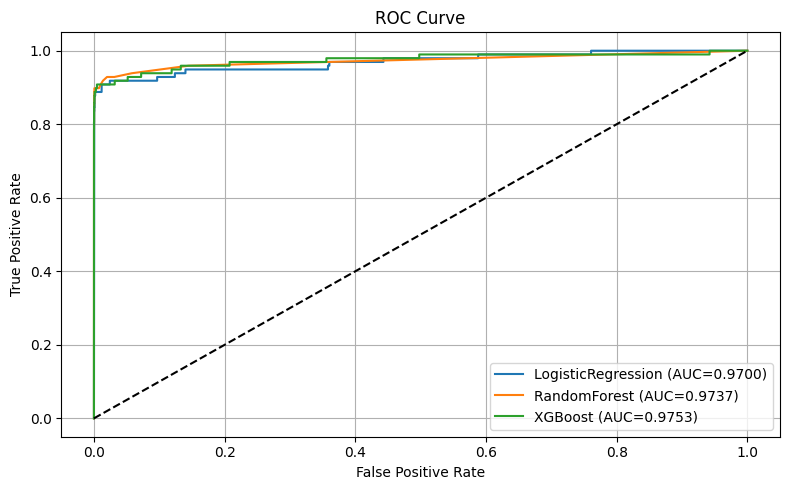

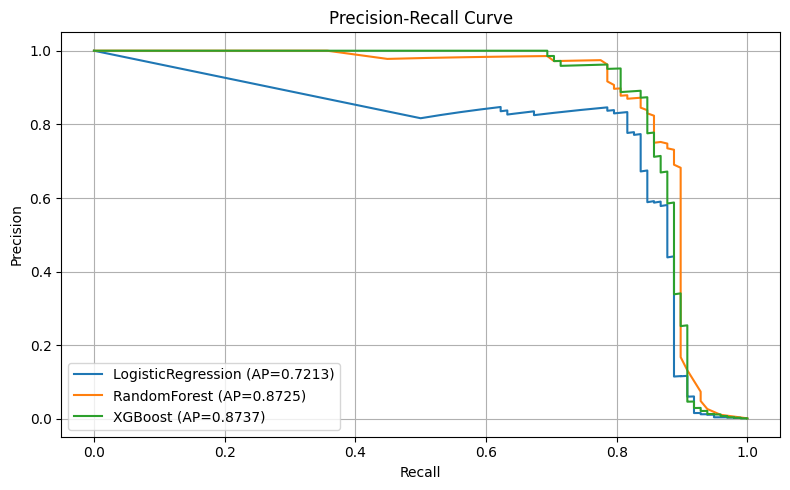

In [26]:
# ------------------------
# Plotting: ROC and PR curves
# ------------------------
if len(results) == 0:
    print('No models trained — skipping plots')
else:
    plt.figure(figsize=(8, 5))
    for name, r in results.items():
        fpr, tpr, _ = roc_curve(y_test, r['y_proba'])
        plt.plot(fpr, tpr, label=f"{name} (AUC={r['roc_auc']:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('roc_curve.png')
    plt.show()

    plt.figure(figsize=(8, 5))
    for name, r in results.items():
        precision, recall, _ = precision_recall_curve(y_test, r['y_proba'])
        plt.plot(recall, precision, label=f"{name} (AP={r['average_precision']:.4f})")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('pr_curve.png')
    plt.show()

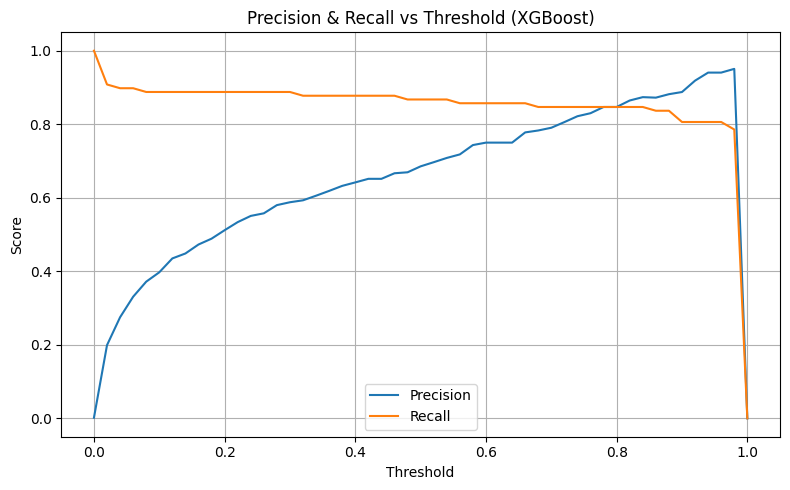

In [27]:

# ------------------------
# Threshold tuning example (XGBoost if present)
# ------------------------
model_to_plot = 'XGBoost'
if model_to_plot in results:
    thresholds = np.linspace(0, 1, 51)
    precisions = []
    recalls = []
    y_proba = results[model_to_plot]['y_proba']
    for t in thresholds:
        y_t = (y_proba >= t).astype(int)
        tp = int(((y_test == 1) & (y_t == 1)).sum())
        fp = int(((y_test == 0) & (y_t == 1)).sum())
        fn = int(((y_test == 1) & (y_t == 0)).sum())
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        precisions.append(prec)
        recalls.append(rec)
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, recalls, label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'Precision & Recall vs Threshold ({model_to_plot})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('threshold_precision_recall.png')
    plt.show()


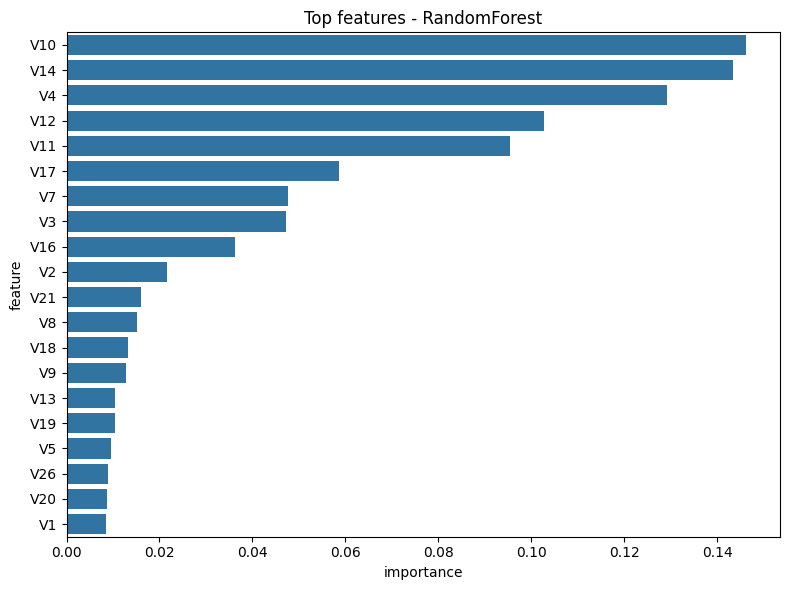

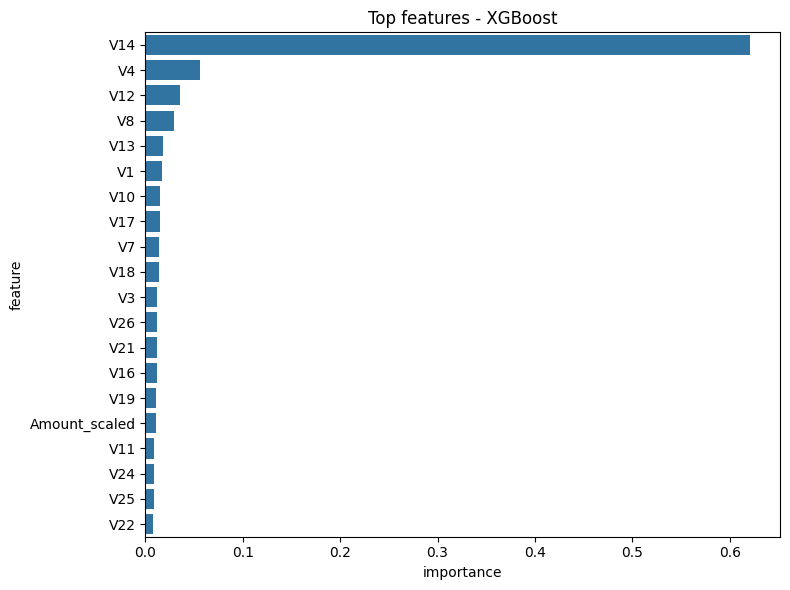

In [28]:
# ------------------------
# Feature importances
# ------------------------
for name in ['RandomForest', 'XGBoost']:
    if name in results:
        model = results[name]['model']
        try:
            fi = model.feature_importances_
            cols = X_train.columns
            fi_df = pd.DataFrame({'feature': cols, 'importance': fi}).sort_values('importance', ascending=False).head(20)
            plt.figure(figsize=(8, 6))
            sns.barplot(x='importance', y='feature', data=fi_df)
            plt.title(f'Top features - {name}')
            plt.tight_layout()
            plt.savefig(f'{name}_feature_importance.png')
            plt.show()
        except Exception as e:
            print('Could not get feature importance for', name, e)

In [30]:

# ------------------------
# Save evaluation summary
# ------------------------
summary = []
for name, r in results.items():
    summary.append({'model': name, 'roc_auc': r['roc_auc'], 'average_precision': r['average_precision']})
summary_df = pd.DataFrame(summary).sort_values('roc_auc', ascending=False)
summary_df.to_csv('model_summary.csv', index=False)

print('\nSaved: roc_curve.png, pr_curve.png, threshold_precision_recall.png, model_summary.csv and model .joblib files')


Saved: roc_curve.png, pr_curve.png, threshold_precision_recall.png, model_summary.csv and model .joblib files


In [31]:
# ------------------------
# Minimal smoke tests
# ------------------------
# These tests run automatically when the script is executed. They are lightweight and
# only check that key pipeline steps complete successfully.

def _run_smoke_tests():
    print('\nRunning smoke tests...')
    # Test 1: Dataframe has Class column
    assert 'Class' in df.columns, "SmokeTest Failed: 'Class' column missing"

    # Test 2: After preprocessing, features and target sizes align
    assert X.shape[0] == df.shape[0], 'SmokeTest Failed: feature rows != original rows'
    assert y.shape[0] == df.shape[0], 'SmokeTest Failed: target rows != original rows'

    # Test 3: SMOTE produced at least one positive sample in training
    assert sum(y_train_res) >= 1, 'SmokeTest Failed: SMOTE produced zero positive samples'

    # Test 4: At least one model trained and produced an AUC in (0,1]
    assert len(results) >= 1, 'SmokeTest Failed: No models trained'
    for name, r in results.items():
        assert 0.0 < r['roc_auc'] <= 1.0, f"SmokeTest Failed: {name} auc out of bounds: {r['roc_auc']}"

    print('All smoke tests passed.')


In [32]:


# Only run smoke tests when executed as a script (not when imported)
if __name__ == '__main__':
    _run_smoke_tests()


Running smoke tests...
All smoke tests passed.


Conclusion — Credit Card Fraud Detection Project

This project successfully demonstrates a scalable, data-driven approach to identifying fraudulent credit card transactions. By leveraging SMOTE for imbalance handling and comparing multiple machine-learning models, the system achieves strong predictive performance while minimizing false negatives — a critical factor in fraud prevention.